<a href="https://colab.research.google.com/github/ritikumra/Lung-Cancer-Patient-Follow-Up-Prediction/blob/main/Oncology_Patients_Follow_Up_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/ritikumra/Lung-Cancer-Patient-Follow-Up-Prediction/refs/heads/main/LungNodule_PatientFollowUps.csv")

# Encode categorical columns
label_encoders = {}
categorical_cols = ['Gender', 'AgeGroup', 'Comorbidities', 'FamilyHistoryCancer',
                    'SelfHistoryCancer', 'LungRadScore', 'FollowUpInterval']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalize numerical features
scaler = MinMaxScaler()
df[['SmokingPackYears', 'TumorSize_mm']] = scaler.fit_transform(df[['SmokingPackYears', 'TumorSize_mm']])

# Sort for sequence alignment
df = df.sort_values(by=['PatientID', 'FollowUpNumber'])

In [3]:


# Encode all categorical columns
df_encoded = df.copy()
for col in ['Gender', 'AgeGroup', 'Comorbidities', 'FamilyHistoryCancer', 'SelfHistoryCancer', 'LungRadScore']:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Drop non-feature columns for X
features_df = df_encoded.drop(['PatientID', 'FollowUpNumber', 'FollowUpInterval'], axis=1)


In [4]:
df

,PatientID,Gender,AgeGroup,Comorbidities,FamilyHistoryCancer,SelfHistoryCancer,SmokingPackYears,FollowUpNumber,TumorSize_mm,LungRadScore,FollowUpInterval
0,P001,1,0,0,1,1,0.020833,1,0.346154,2,1
1,P001,1,0,0,1,1,0.020833,2,0.318681,1,2
2,P001,1,0,0,1,1,0.020833,3,0.346154,2,1
3,P001,1,0,0,1,1,0.020833,4,0.346154,2,1
4,P001,1,0,0,1,1,0.020833,5,0.346154,2,1
...,...,...,...,...,...,...,...,...,...,...,...
2495,P500,0,3,0,0,0,0.569444,1,0.450549,2,1
2496,P500,0,3,0,0,0,0.569444,2,0.450549,2,1
2497,P500,0,3,0,0,0,0.569444,3,0.505495,2,1
2498,P500,0,3,0,0,0,0.569444,4,0.478022,2,1


In [5]:
import numpy as np

# Group by PatientID and create sequences
grouped = df_encoded.groupby('PatientID')

X_sequences = []
for pid, group in grouped:
    group_sorted = group.sort_values(by='FollowUpNumber')
    features = group_sorted.drop(['PatientID', 'FollowUpNumber', 'FollowUpInterval'], axis=1).values
    X_sequences.append(features)

# Pad sequences to the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_padded = pad_sequences(X_sequences, padding='post', dtype='float32')  # shape: (n_patients, max_seq_len, n_features)


In [6]:
# Get last follow-up interval for each patient
y_labels = grouped.tail(1)['FollowUpInterval'].values

# Encode follow-up intervals (e.g., '3 months', '12 months')
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y_labels)

# Convert to one-hot
from tensorflow.keras.utils import to_categorical
y_onehot = to_categorical(y_encoded)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_onehot, test_size=0.2, random_state=42
)

# Get shapes
timesteps = X_train.shape[1]
features = X_train.shape[2]
num_classes = y_onehot.shape[1]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, features)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=40, batch_size=8, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3169 - loss: 1.2780 - val_accuracy: 0.5625 - val_loss: 1.0808
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6559 - loss: 0.9165 - val_accuracy: 0.7875 - val_loss: 0.7805
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8520 - loss: 0.6580 - val_accuracy: 0.8375 - val_loss: 0.5643
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8648 - loss: 0.4458 - val_accuracy: 0.8625 - val_loss: 0.3920
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8894 - loss: 0.3401 - val_accuracy: 0.8375 - val_loss: 0.3209
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8835 - loss: 0.2850 - val_accuracy: 0.9375 - val_loss: 0.2064
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9151 - loss: 0.2234 - val_accuracy: 0.9375 - val_loss: 0.2342
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9395 - loss: 0.1976 - val_accuracy: 0.9625 - val_los

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


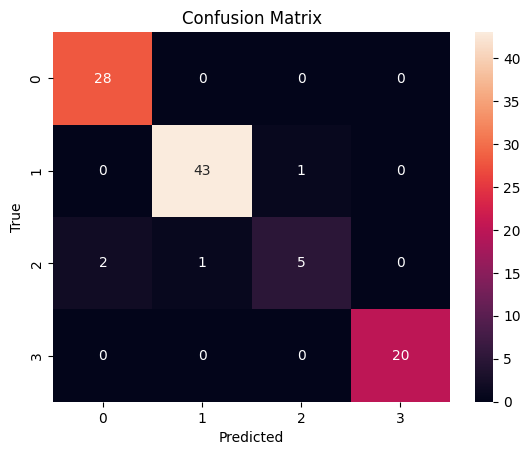

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Decode to original labels
y_pred_labels = le_y.inverse_transform(y_pred)
y_true_labels = le_y.inverse_transform(y_true)

# Plot confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le_y.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [10]:
print(classification_report(y_true_labels, y_pred_labels))


              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       0.98      0.98      0.98        44
           2       0.83      0.62      0.71         8
           3       1.00      1.00      1.00        20

    accuracy                           0.96       100
   macro avg       0.94      0.90      0.91       100
weighted avg       0.96      0.96      0.96       100



In [11]:
model.save("followup_lstm_model.h5")


In [12]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


In [13]:
# example saving
import joblib
joblib.dump(model, 'model.pkl')


['model.pkl']

In [80]:
joblib.dump(le_y, 'label_encoder.pkl')


['label_encoder.pkl']

In [16]:
!pip install streamlit pyngrok --quiet


In [86]:
from sklearn.preprocessing import LabelEncoder
import pickle

# Replace this list with the actual list of follow-up labels used
labels = ["1 month", "3 months", "6 months", "12 months"]

le = LabelEncoder()
le.fit(labels)

# Save it
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [92]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
import pickle
from sklearn.preprocessing import LabelEncoder

# Load the trained model
model = tf.keras.models.load_model('followup_lstm_model.h5')

# Load label encoder used during training
with open('label_encoder.pkl', 'rb') as file:
    le = pickle.load(file)

st.title("Lung Follow-Up Interval Predictor")

# Collect input from user
age_group = st.selectbox("Age Group", ['18-30', '31-45', '46-60', '61-75', '75+'])
comorbidities = st.number_input("Number of Comorbidities", min_value=0, max_value=10, step=1)
family_history = st.selectbox("Family History of Cancer", ['Yes', 'No'])
self_history = st.selectbox("Self History of Cancer", ['Yes', 'No'])
smoking_pack_years = st.number_input("Smoking Pack Years", min_value=0.0, max_value=100.0, step=1.0)
followup_number = st.number_input("Follow-Up Number", min_value=1, max_value=10, step=1)
tumor_size = st.number_input("Tumor Size (mm)", min_value=0.0, max_value=100.0, step=0.1)
lung_rad_score = st.selectbox("Lung-RADS Score", [1, 2, 3, 4])

if st.button("Predict Follow-Up Interval"):
    # Map categorical inputs to numerical as per training encoding
    age_map = {'18-30': 0, '31-45': 1, '46-60': 2, '61-75': 3, '75+': 4}
    yes_no_map = {'Yes': 1, 'No': 0}

    # Prepare feature vector
    features = [
        age_map[age_group],
        comorbidities,
        yes_no_map[family_history],
        yes_no_map[self_history],
        smoking_pack_years,
        followup_number,
        tumor_size,
        lung_rad_score
    ]

    # Convert to NumPy array and reshape: (1, 5, 8)
    input_data = np.array(features, dtype=np.float32).reshape((1, 1, 8))


    # Predict class probabilities
    pred_probs = model.predict(input_data)
    pred_class = np.argmax(pred_probs, axis=1)[0]

    # Decode class to label
    follow_up_interval = le.inverse_transform([pred_class])[0]

    st.success(f"🩺 Recommended Follow-Up Interval: **{follow_up_interval}**")




Overwriting app.py


In [93]:
!ngrok config add-authtoken 308VpnoOCO5xxbiQbV27aS9sRVb_6n46jDAS3Nzupn4QjJsYL

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [94]:
from pyngrok import ngrok
ngrok.kill()

In [95]:
import os
os.system("streamlit run app.py --server.port 8555 &")

0

In [96]:
public_url = ngrok.connect(8555)
print(f"🔗 Your Streamlit app is live at: {public_url}")

🔗 Your Streamlit app is live at: NgrokTunnel: "https://5c10f128161f.ngrok-free.app" -> "http://localhost:8555"


In [36]:
from tensorflow.keras.models import load_model

model = load_model("followup_lstm_model.h5")
model.summary()

print("Expected model input shape:", model.input_shape)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,950 (74.03 KB)

 Trainable params: 18,948 (74.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Expected model input shape: (None, 5, 8)


In [79]:
!ls -l /content


total 508
-rw-r--r-- 1 root root   1996 Jul 20 12:05 app.py
-rw-r--r-- 1 root root 252280 Jul 20 10:54 followup_lstm_model.h5
-rw-r--r-- 1 root root    359 Jul 20 12:05 label_encoder.pkl
-rw-r--r-- 1 root root 251260 Jul 20 10:55 model.pkl
drwxr-xr-x 1 root root   4096 Jul 16 13:48 sample_data
